# Cancer Detection

In this Jupyter Notebook, we will aim to create a CNN model which will accurately detect if cancer is present based on pathology images.

The data was retrieved from the following Kaggle competition: Histopathologic Cancer detection. Kaggle. (n.d.). Retrieved April 23, 2022, from https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview 

Import necessary libraries

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [119]:
from skimage.io import imread

Convert train images to RGB values and then place them into a list using a for loop

In [120]:
import os
path = 'train'
directory = os.listdir(path)

In [121]:
train = []

In [226]:
# make sure for loop only picks up files that end with tif

In [122]:
for file in directory:
    if file[-3:] == 'tif':
        image = imread(f'train/{file}',plugin='matplotlib')
        train.append(image)
    else:
        pass

Do the same for the test images

In [123]:
test= []

In [124]:
path = 'test'
directory = os.listdir(path)

In [125]:
for file in directory:
    if file[-3:] == 'tif':
        image = imread(f'test/{file}',plugin='matplotlib')
        test.append(image)
    else:
        pass

Let's take a look at the first image in the training dataset. This is a non-cancerous image, according to the training labels

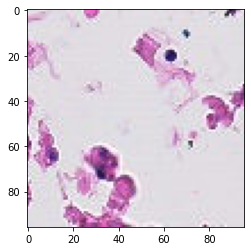

In [126]:
plt.imshow(train[0])

Let's take a look at image 101 in the training dataset. This is also a non-cancerous image

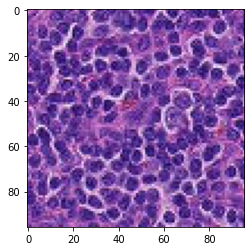

In [127]:
plt.imshow(train[100])

Let's take a look at image 201 in the training dataset. This is a cancerous image

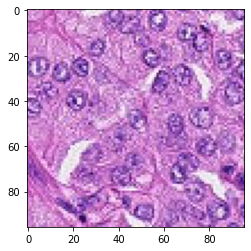

In [128]:
plt.imshow(train[200])

Make sure the training labels are in the same order as the training dataset above

In [129]:
train_labels = pd.read_csv('train_labels.csv')

In [130]:
train_labels1 = train_labels.set_index('id')

In [131]:
path = 'train'
directory = os.listdir(path)
directory1 = []
for file in directory:
    if file[-3:] == 'tif':
        directory1.append(file[:-4])

In [132]:
train_labels = train_labels1.loc[directory1]

In [133]:
train_labels = train_labels['label']

You can see that there are more non-cancerous images in the training set than cancerous ones

<AxesSubplot:>

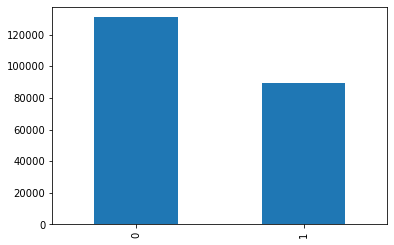

In [207]:
train_labels.value_counts().plot(kind='bar')

Convert train and test into numpy arrays

In [134]:
train = np.array(train)
test = np.array(test)

train.shape shows that train has 220,025 images with each image having a shape of 96x96x3

In [135]:
train.shape

(220025, 96, 96, 3)

test.shape shows that there are 57,458 images in the test dataset with each image having a shape of 96x96x3

In [136]:
test.shape

(57458, 96, 96, 3)

Since we do not have labels for the test data, let's split the train data into train and validation sets. We will use an 80/20 split

In [137]:
from sklearn.model_selection import train_test_split

In [138]:
X_train, X_valid, y_train, y_valid = train_test_split(train, train_labels, test_size=0.2, random_state=42)

In [179]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

Let's create our CNN model now. We will use just two convolutional layers for our project to speed up training time, use a stride of 2 in order to prevent overfitting, batch normalization for regularization, max pool to prevent overfitting, then two dense layers at the end. Activation functions will be relu for all except for the output layer, which will be sigmoid since this is a binary classification problem. We will use binary_crossentropy for the loss function and adam as the optimizer. We will adjust the learning rate for adam to be 0.0001 in order to prevent overfitting. If we had more time, we could add more convolutional layers to this model but for our case we will proceed by using just two convolutional layers. We could also slow down the learning rate further but we will keep it at the 0.0001 that we set

In [227]:
# put optimizer into a variable so you can easily adjust it outside the codeblock with the actual model

In [212]:
optimizer = Adam(learning_rate=0.0001)

In [213]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(96,96,3),activation='relu',strides=(2,2)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',strides=(2,2)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics='accuracy')

Early stopping also prevents overfitting. We will set patience to be equal to 2

In [214]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss',patience=2)

Let's use 20 as epochs when fitting our train data. You can see that it stopped after the fourth epoch due to our callback function

In [215]:
model.fit(X_train,y_train,epochs=20,callbacks=early,validation_data=(X_valid,y_valid))

Epoch 1/20
5501/5501 [==============================] - 179s 32ms/step - loss: 0.4172 - accuracy: 0.8152 - val_loss: 0.3718 - val_accuracy: 0.8361
Epoch 2/20
5501/5501 [==============================] - 180s 33ms/step - loss: 0.3473 - accuracy: 0.8500 - val_loss: 0.3406 - val_accuracy: 0.8536
Epoch 3/20
5501/5501 [==============================] - 196s 36ms/step - loss: 0.3111 - accuracy: 0.8682 - val_loss: 0.3791 - val_accuracy: 0.8426
Epoch 4/20
5501/5501 [==============================] - 201s 37ms/step - loss: 0.2788 - accuracy: 0.8830 - val_loss: 0.3515 - val_accuracy: 0.8521


Here is a table of the loss, accuracy, val_loss, and val_accuracy through all four epochs

In [216]:
pd.DataFrame(model.history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.417163,0.815180,0.371774,0.836132
1,0.347296,0.850028,0.340627,0.853630
2,0.311097,0.868202,0.379113,0.842563
3,0.278765,0.882968,0.351479,0.852062


Plot of loss vs. val_loss

<AxesSubplot:>

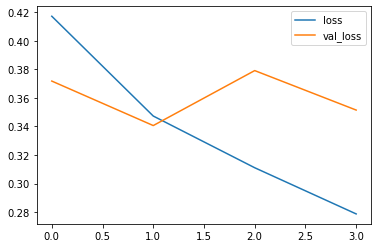

In [217]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

Plot of accuracy vs. val_accuracy

<AxesSubplot:>

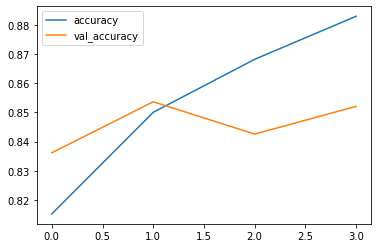

In [218]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()

The model above was a result of hyperparameter tuning. It was not the first model I trained for this project. When I tuned, I made sure to look at how long each epoch was taking. If the epoch was taking too long, I would remove layers or increase the learning rate to speed up training. I also took a look at validation accuracy and validation loss because those metrics are signs of how well the model would do with data it has not seen before. If they were out of the range of values I would be satisfied with, I took a look at the hyperparameters and adjusted them so I could get better performance with the validation data

We ended with an 85.2062% validation accuracy which is pretty good, considering it took just four epochs. This project taught me the importance of hyperparameter tuning, as they could affect the performance of your model tremendously. I also learned that training these models take a lot of time since we were using a large dataset. Hyperparameter tuning will help you realize what works and what does not work. It will help you prevent overfitting as well, which is important when training your model. Again, we can decrease the learning rate or add more convolutional layers for potentially better performance

Let's predict on the test dataset and round so we can get 1's and 0's

In [219]:
pred = np.round(model.predict(test))

Let's create a df that looks like the sample submission file on Kaggle

In [220]:
path = 'test'
directory = os.listdir(path)
directory1 = []
for file in directory:
    if file[-3:] == 'tif':
        directory1.append(file[:-4])

In [221]:
pred1 = []
for number in pred:
    pred1.append(number[0])

In [222]:
data = {'id':directory1,'label':pred1}

In [223]:
df = pd.DataFrame(data=data)
df = df.set_index('id')

According to the competition, the submission should have 57,458 prediction rows, which ours does

In [224]:
len(df)

57458

Let's make sure the samples are in the correct order as the sample submission csv

In [229]:
sample = pd.read_csv('sample_submission.csv')

In [234]:
df = df.loc[sample['id']]

Let's create a csv file in our current working directory so we can submit it to the Kaggle competition

In [235]:
df.to_csv('predictions2.csv')